Total dataset size: 760
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected features after SelectKBest: ['RBC', 'Hb', 'HCT', 'RDW-CV', 'BP', 'Diabetes', 'Age', 'Gender']

--- XGBoost Classifier with GridSearchCV ---
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best ROC AUC score from GridSearchCV (XGBoost): 0.8175
Accuracy: 0.72
ROC AUC Score: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.51      0.65        76
           1       0.66      0.93      0.77        76

    accuracy                           0.72       152
   macro avg       0.77      0.72      0.71       152
weighted avg       0.77      0.72      0.71       152

Predictions saved to predictions_xgboost_tuned.csv

Count of samples by Anemia Severity and Predicted Probability Range:
Probability_Range  1-20%  21-40%  41-60%  61-80%  81-100%
Anemia_Severity                                          
Mild                  10       6       6      12        4
Moderate              13       4      10      24       16
None                   9       9       7      12        5
Sev

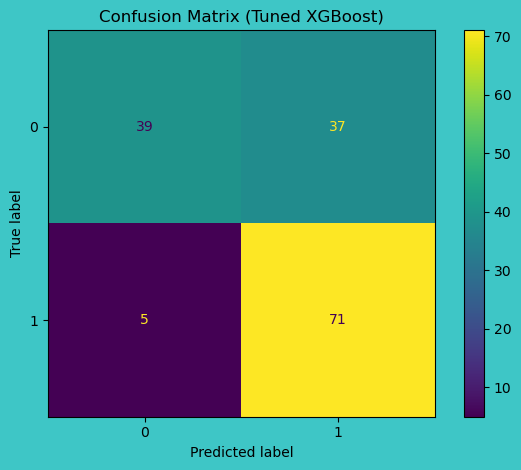

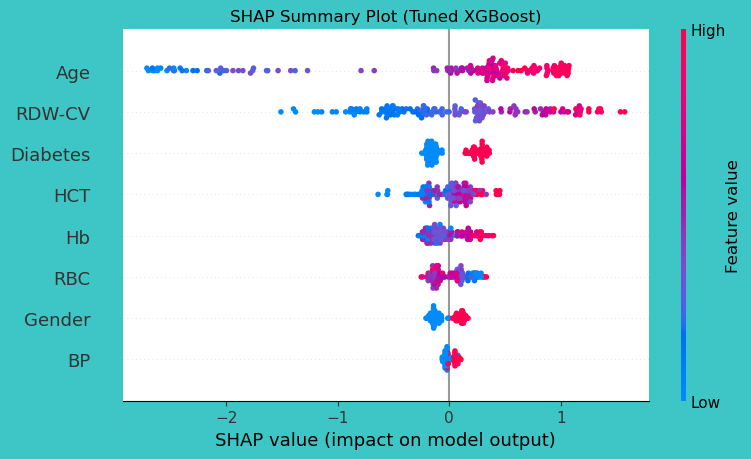

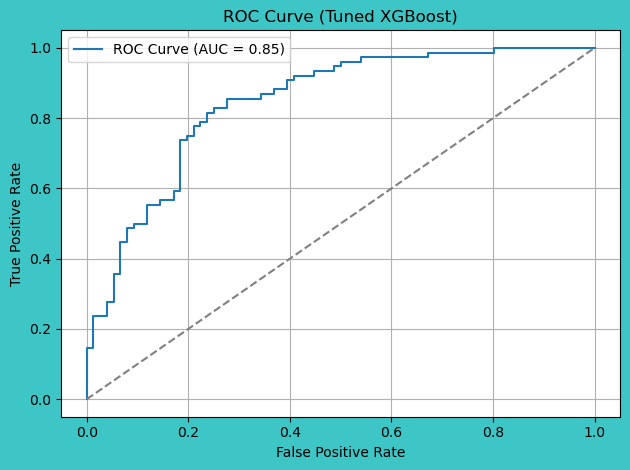

Number of patients with Anemia and Heart Disease: 285


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from xgboost import XGBClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=min(8, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)
selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print("Selected features after SelectKBest:", selected_features)

# --- START OF HYPERPARAMETER TUNING FOR XGBOOST CLASSIFIER ---
print("\n--- XGBoost Classifier with GridSearchCV ---")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit without SMOTE
grid_search_xgb.fit(X_train_selected, y_train)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print(f"Best ROC AUC score from GridSearchCV (XGBoost): {grid_search_xgb.best_score_:.4f}")

# Predict
model = grid_search_xgb.best_estimator_
predicted_proba = model.predict_proba(X_test_selected)[:, 1]
predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()
if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

bins = [1, 20, 40, 60, 80, 100]
labels = ['1-20%', '21-40%', '41-60%', '61-80%', '81-100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)
predictions_df.to_csv('predictions_xgboost_tuned.csv')
print("Predictions saved to predictions_xgboost_tuned.csv")

print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Count of patients with both Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
print(f"Number of patients with Anemia and Heart Disease: {anemia_and_hd.shape[0]}")
